<a href="https://colab.research.google.com/github/singhmegh/Iris_image_Disorder_Detection-/blob/main/iris_eye.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install kaggle


!mkdir -p ~/.kaggle
!cp /content/kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [9]:
!kaggle datasets download -d gunavenkatdoddi/eye-diseases-classification

Dataset URL: https://www.kaggle.com/datasets/gunavenkatdoddi/eye-diseases-classification
License(s): ODbL-1.0
 97% 712M/736M [00:07<00:00, 173MB/s]
100% 736M/736M [00:07<00:00, 102MB/s]


In [10]:
!unzip -q eye-diseases-classification.zip -d eye_diseases_dataset

In [14]:
!ls

eye-diseases-classification.zip  eye_diseases_dataset  kaggle.json  sample_data


In [16]:
import os, shutil

src_path = "/content/eye_diseases_dataset/dataset"
binary_path = "/content/eye_diseases_binary"

os.makedirs(os.path.join(binary_path, "healthy"), exist_ok=True)
os.makedirs(os.path.join(binary_path, "diseased"), exist_ok=True)

def copy_images_for_binary():
    for cls in os.listdir(src_path):
        cls_path = os.path.join(src_path, cls)
        if not os.path.isdir(cls_path):
            continue

        if cls.lower() == "normal":
            target_folder = os.path.join(binary_path, "healthy")
        else:
            target_folder = os.path.join(binary_path, "diseased")

        for root, _, files in os.walk(cls_path):
            for img_file in files:
                src_file = os.path.join(root, img_file)
                dst_file = os.path.join(target_folder, img_file)
                shutil.copy(src_file, dst_file)

copy_images_for_binary()
print("Images copied into binary structure")

Images copied into binary structure


In [17]:
for folder in ["healthy", "diseased"]:
    print(folder, ":", len(os.listdir(os.path.join(binary_path, folder))), "images")

healthy : 1074 images
diseased : 3141 images


**Preprocessing**

In [18]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

img_size = (224,224)
batch_size = 32

datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

train_gen = datagen.flow_from_directory(
    "/content/eye_diseases_binary",
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary',
    subset='training'
)

val_gen = datagen.flow_from_directory(
    "/content/eye_diseases_binary",
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary',
    subset='validation'
)

Found 3373 images belonging to 2 classes.
Found 842 images belonging to 2 classes.


**Model Building (Transfer Learning – MobileNetV2)**

In [19]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam

In [20]:
base_model = MobileNetV2(weights="imagenet", include_top=False, input_shape=(224,224,3))
base_model.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation="relu")(x)
output = Dense(1, activation="sigmoid")(x)

model = Model(inputs=base_model.input, outputs=output)
model.compile(optimizer=Adam(learning_rate=1e-4), loss="binary_crossentropy", metrics=["accuracy"])

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [21]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,422,081 (9.24 MB)

 Trainable params: 164,097 (641.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

**Training the Model**

In [22]:
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=3,
    verbose=1
)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/3
106/106 ━━━━━━━━━━━━━━━━━━━━ 68s 480ms/step - accuracy: 0.7121 - loss: 0.5208 - val_accuracy: 0.7815 - val_loss: 0.4279
Epoch 2/3
106/106 ━━━━━━━━━━━━━━━━━━━━ 26s 243ms/step - accuracy: 0.8684 - loss: 0.3050 - val_accuracy: 0.8349 - val_loss: 0.3588
Epoch 3/3
106/106 ━━━━━━━━━━━━━━━━━━━━ 26s 241ms/step - accuracy: 0.8907 - loss: 0.2561 - val_accuracy: 0.8575 - val_loss: 0.3241


**Evaluation (Accuracy, Confusion Matrix, Plots)**

In [23]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np

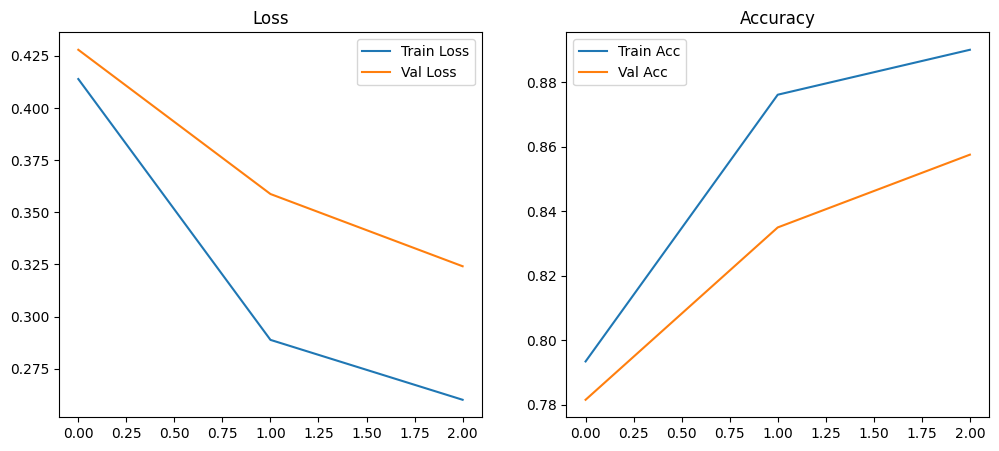

In [25]:
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title("Loss")

plt.subplot(1,2,2)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.legend()
plt.title("Accuracy")
plt.show()

27/27 ━━━━━━━━━━━━━━━━━━━━ 11s 226ms/step


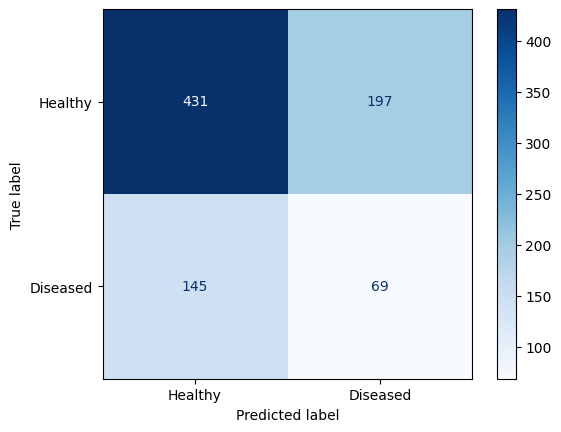

In [26]:
val_gen.reset()
y_pred = (model.predict(val_gen) > 0.5).astype(int)
y_true = val_gen.classes

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(cm, display_labels=["Healthy","Diseased"])
disp.plot(cmap=plt.cm.Blues)
plt.show()

**Grad-CAM**

In [27]:
import cv2
import tensorflow.keras.backend as K
import numpy as np
import matplotlib.cm as cm

In [31]:
def make_gradcam_heatmap(img_array, model, last_conv_layer_name="Conv_1"):
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        loss = predictions[:, 0]

    grads = tape.gradient(loss, conv_outputs)
    pooled_grads = K.mean(grads, axis=(0,1,2))
    conv_outputs = conv_outputs[0]
    heatmap = tf.reduce_mean(tf.multiply(pooled_grads, conv_outputs), axis=-1)

    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap)

    return heatmap

In [33]:
import matplotlib.cm as cm

def overlay_gradcam(img, heatmap, alpha=0.4):
    heatmap = np.uint8(255 * heatmap)


    jet = cm.get_cmap("jet")

    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    jet_heatmap = tf.keras.utils.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = tf.keras.utils.img_to_array(jet_heatmap)

    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = tf.keras.utils.array_to_img(superimposed_img)

    return superimposed_img

/tmp/ipython-input-986923577.py:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  jet = cm.get_cmap("jet")


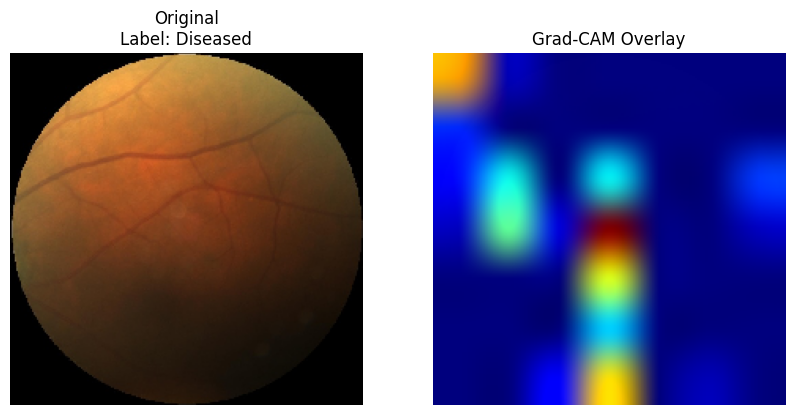

In [46]:
import matplotlib.pyplot as plt

idx = 20
img, label = val_gen[0][0][idx], val_gen[0][1][idx]
img_input = np.expand_dims(img, axis=0)

heatmap = make_gradcam_heatmap(img_input, model)

# Overlay heatmap on original image
gradcam_result = overlay_gradcam(img, heatmap)

# Display side by side
plt.figure(figsize=(10,5))

# Original image
plt.subplot(1,2,1)
plt.imshow(img)
plt.title(f"Original\nLabel: {'Healthy' if label==0 else 'Diseased'}")
plt.axis("off")

# Grad-CAM overlay
plt.subplot(1,2,2)
plt.imshow(gradcam_result)
plt.title("Grad-CAM Overlay")
plt.axis("off")

plt.show()

In [49]:
import os
import numpy as np

# Create folder to save Grad-CAM images
save_folder = "/content/gradcam_images"
os.makedirs(save_folder, exist_ok=True)

healthy_indices = []
diseased_indices = []

for batch_num in range(len(val_gen)):
    imgs, labels = val_gen[batch_num]
    for i in range(len(labels)):
        if labels[i] == 0 and len(healthy_indices) < 2:
            healthy_indices.append((batch_num, i))
        elif labels[i] == 1 and len(diseased_indices) < 2:
            diseased_indices.append((batch_num, i))
    if len(healthy_indices) == 2 and len(diseased_indices) == 2:
        break

def save_gradcam(batch_idx, idx_in_batch, prefix):
    img = val_gen[batch_idx][0][idx_in_batch]
    label = val_gen[batch_idx][1][idx_in_batch]

    img_input = np.expand_dims(img, axis=0)
    heatmap = make_gradcam_heatmap(img_input, model)
    gradcam_result = overlay_gradcam(img, heatmap)

    filename = f"{prefix}_{'healthy' if label==0 else 'diseased'}.png"
    gradcam_result.save(os.path.join(save_folder, filename))
    print("Saved:", filename)

for i, (batch_idx, idx_in_batch) in enumerate(healthy_indices):
    save_gradcam(batch_idx, idx_in_batch, f"healthy_{i+1}")

for i, (batch_idx, idx_in_batch) in enumerate(diseased_indices):
    save_gradcam(batch_idx, idx_in_batch, f"diseased_{i+1}")

print("\nAll Grad-CAM images saved in:", save_folder)

/usr/local/lib/python3.12/dist-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['keras_tensor']]
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)
/tmp/ipython-input-986923577.py:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  jet = cm.get_cmap("jet")


Saved: healthy_1_healthy.png
Saved: healthy_2_healthy.png
Saved: diseased_1_diseased.png
Saved: diseased_2_diseased.png

All Grad-CAM images saved in: /content/gradcam_images


**Outcomes**

In [50]:
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

In [51]:
def predict_with_gradcam(img_path, model, img_size=(224,224), alpha=0.4, last_conv_layer="Conv_1"):
    """
    Input:
        img_path : path to new iris image
        model : trained Keras model
        img_size : target image size
        alpha : transparency for overlay
        last_conv_layer : last conv layer in model (MobileNetV2 default "Conv_1")
    Output:
        Shows original image, Grad-CAM overlay, and prints prediction
    """

    img = image.load_img(img_path, target_size=img_size)
    img_array = image.img_to_array(img)
    img_input = np.expand_dims(img_array, axis=0) / 255.0


    pred_prob = model.predict(img_input)[0][0]
    label = "Healthy" if pred_prob < 0.5 else "Diseased"
    print(f"Prediction: {label} (prob={pred_prob:.2f})")


    heatmap = make_gradcam_heatmap(img_input, model, last_conv_layer_name=last_conv_layer)


    overlay = overlay_gradcam(img_array, heatmap, alpha=alpha)


    plt.figure(figsize=(10,5))
    plt.subplot(1,2,1)
    plt.imshow(img_array/255.0)
    plt.title("Original Image")
    plt.axis("off")

    plt.subplot(1,2,2)
    plt.imshow(overlay)
    plt.title("Grad-CAM Overlay")
    plt.axis("off")

    plt.show()

Enter the path/content/eye_diseases_binary/diseased/10010_left.jpeg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Prediction: Healthy (prob=0.02)


/tmp/ipython-input-986923577.py:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  jet = cm.get_cmap("jet")


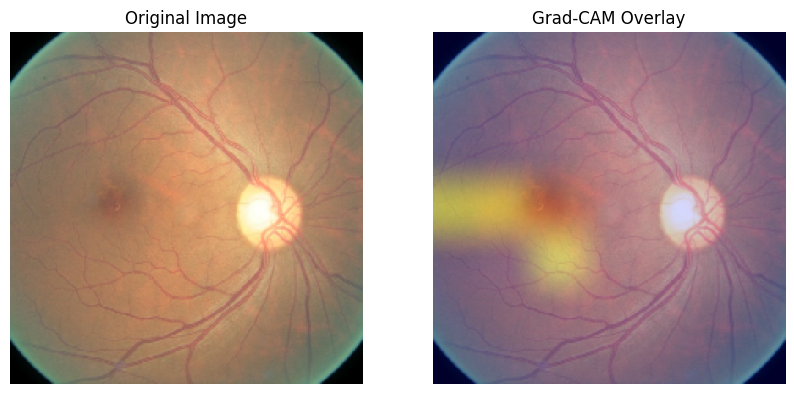

In [61]:
# Replace with any new iris image path
new_img_path = input("Enter the path")
predict_with_gradcam(new_img_path, model)